# Imports

In [ ]:
!pip install -Uqq fastbook

     |████████████████████████████████| 727kB 29.4MB/s 
     |████████████████████████████████| 194kB 44.2MB/s 
     |████████████████████████████████| 51kB 8.2MB/s 
     |████████████████████████████████| 1.2MB 18.6MB/s 
     |████████████████████████████████| 61kB 8.6MB/s 
     |████████████████████████████████| 61kB 10.6MB/s 


In [ ]:
import fastbook
fastbook.setup_book()

Mounted at /content/gdrive


In [ ]:
from fastai.text.all import *
import pandas as pd

In [ ]:
!wget https://github.com/tkurosaka/toxic-comment-classification/blob/master/data/train.csv

# New Section

In [ ]:
from fastai.text.all import *

In [ ]:
df = pd.read_csv('train.csv')
df.columns = ['id', 'comment_text', 'identity_theft', 'weapons', 'carding', 'ransomeware', 'label1', 'label2']

In [ ]:
df.head(2)

,id,comment_text,identity_theft,weapons,carding,ransomeware,label1,label2
0,1,Welcome to firearms72 Deep Web Weapon Shop!,0,1,0,0,0,0
1,2,The GLOCK 26 Gen4 in 9mm Luger is one of the most sought-after concealed carry pistols.,0,1,0,0,0,0


In [ ]:
def make_y(df, i=2, k = 2):
  val_name = df.columns[i:-k]
  values = df.iloc[:, i:-k].values
  return [' '.join(list(val_name[np.where(values[i, :])])) for i in range(len(values))]

df['category'] = make_y(df)
df.drop(['identity_theft', 'weapons', 'carding', 'ransomeware', 'label1', 'label2', 'id'], axis=1, inplace=True)

In [ ]:
df.head(2)

,comment_text,category
0,Welcome to firearms72 Deep Web Weapon Shop!,weapons
1,The GLOCK 26 Gen4 in 9mm Luger is one of the most sought-after concealed carry pistols.,weapons


In [ ]:
dls_lm = DataBlock(
    blocks = TextBlock.from_df('comment_text', is_lm = True, min_freq=1),
    get_x=ColReader('text'),
    splitter=RandomSplitter(0.1)
).dataloaders(df, bs=6, seq_len=10)



/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
dls_lm.show_batch()

,text,text_
0,xxbos xxmaj irish original passports for sale xxbos xxup cz,xxmaj irish original passports for sale xxbos xxup cz is
1,or an exit with your money over time . xxbos,an exit with your money over time . xxbos xxmaj
2,we printed a copy the electronic image was sufficient at,printed a copy the electronic image was sufficient at the
3,characteristics explain why the xxup g26 xxmaj gen4 is the,explain why the xxup g26 xxmaj gen4 is the mainstay
4,end - all of this gun manufacturer . xxbos xxmaj,- all of this gun manufacturer . xxbos xxmaj by
5,protection and it could even protect your life . xxbos,and it could even protect your life . xxbos xxmaj


In [ ]:
learn = language_model_learner(
        dls_lm, AWD_LSTM, drop_mult=0.3,
        metrics=[accuracy, Perplexity()]
).to_fp16()

In [ ]:
dls_lm.valid.show_batch(max_n=2)

,text,text_
0,xxbos xxmaj buy xxmaj real xxmaj passports xxmaj online xxbos,xxmaj buy xxmaj real xxmaj passports xxmaj online xxbos i
1,xxmaj documents to anyone seeking passport services . xxmaj everyone,documents to anyone seeking passport services . xxmaj everyone in


In [ ]:
dls_lm.train.show_batch(max_n=2)

,text,text_
0,xxbos xxmaj welcome to firearms72 xxmaj deep xxmaj web xxmaj,xxmaj welcome to firearms72 xxmaj deep xxmaj web xxmaj weapon
1,for money transfer services we only recommend using coinbase binance,money transfer services we only recommend using coinbase binance or


SuggestedLRs(valley=0.0063095735386013985)

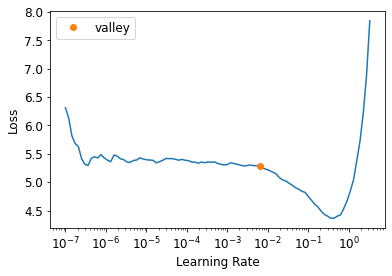

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,5.378561,4.848650,0.225000,127.568115,00:00
1,5.009923,4.738202,0.211111,114.228645,00:00
2,4.690532,4.729144,0.211111,113.198578,00:00


In [ ]:
learn.unfreeze()
learn.fit_one_cycle(10, 3e-3)
learn.save_encoder('finetuned')

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,0.223151,6.857536,0.116667,951.021179,00:00
1,0.218511,6.910408,0.116667,1002.656738,00:00
2,0.249816,6.813374,0.130556,909.935364,00:00
3,0.314748,7.013308,0.102778,1111.324707,00:00
4,0.316568,7.334991,0.108333,1533.014648,00:00
5,0.308513,7.202001,0.102778,1342.113770,00:00
6,0.289940,7.186474,0.094444,1321.435425,00:00
7,0.265031,7.219500,0.094444,1365.806030,00:00
8,0.240461,7.218817,0.122222,1364.873779,00:00
9,0.224333,7.218105,0.108333,1363.902466,00:00


# classification

In [ ]:
def get_y(r): return r['category'].split(' ')
dls_class = DataBlock(
    blocks=(TextBlock.from_df('comment_text', vocab=dls_lm.vocab, is_lm=False), MultiCategoryBlock),
    get_y = get_y,
    get_x = ColReader('text'),
    splitter = RandomSplitter(.1)
).dataloaders(df, bs=10, seq_len=20)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
learn = text_classifier_learner(dls_class, AWD_LSTM, drop_mult=0.5, 
                                metrics=accuracy).to_fp16()
                
learn = learn.load_encoder('finetuned')

In [ ]:
learn.dls.show_batch()

,text,None
0,xxbos xxmaj for a citizen of a totalitarian country or one that holds a passport with poor visa - free travel it means complete freedom of movement along with the right to live and work in a normal developed society . buy real passports buy real licenses driving buy fake passports included .,identity_theft
1,xxbos xxmaj acquiring a second passport ( xxmaj buy passport online buy xxmaj real xxmaj passport for xxmaj sale xxmaj buy xxmaj diplomatic passport xxmaj buy xxmaj dual xxmaj citizenship for sale buy second passport online . buy drivers license ) can expand your rights and freedom to travel .,identity_theft
2,xxbos xxmaj buy xxmaj ammo xxmaj online at xxmaj ammo xxmaj bay xxmaj whether you need ammunition for target practice hunting purposes or defensive measures there is plenty of ammo for sale at xxmaj ammo xxmaj bay from the most popular brands like xxmaj federal xxmaj winchester and more .,weapons
3,xxbos the benefits include free world travel and fewer problems from officious border guards or nosey customs and immigration officials . xxmaj it also gives the right to live and work in any of the 27 xxmaj european xxmaj union member countries .,identity_theft
4,xxbos a second real passports opens doors offshore otherwise closed to xxmaj americans . xxmaj best of all dual citizenship and a second passports can be your key to reduced taxes and increased asset protection and it could even protect your life .,identity_theft
5,xxbos xxmaj sig xxmaj sauer ’s xxup p320 is one of the best - selling guns in xxmaj america the new and improved xxmaj sig pistol is sweeping the nation thanks to its incredible versatility durability and accuracy .,weapons
6,xxbos a common caliber is .22 and is often followed by letters such as .22 l and .22 s which indicate that the bullets are designed to work with long - barrel and short - barrel rifles respectively .,weapons
7,xxbos xxmaj choosing the xxmaj right xxmaj size xxmaj ammo for xxmaj your xxmaj gun . xxmaj before purchasing ammo online consider what type of ammunition works with your existing rifle shotgun pistol or another firearm .,weapons
8,xxbos xxmaj the magazine capacity of 10 rounds is standard and the highly accurate firing characteristics explain why the xxup g26 xxmaj gen4 is the mainstay backup option among security personnel and agencies worldwide .,weapons


In [ ]:
learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,time


AssertionError: ignored

# New Section 2

In [ ]:
!git clone https://www.github.com/tkurosaka/toxic-comment-classification

Cloning into 'toxic-comment-classification'...
remote: Enumerating objects: 53, done.
remote: Total 53 (delta 0), reused 0 (delta 0), pack-reused 53
Unpacking objects: 100% (53/53), done.


In [ ]:
df = pd.read_csv("data/train.csv")
df.columns = ['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [ ]:
df.head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0


In [ ]:
import numpy as np

In [ ]:
value = []
for i in range(len(df)):
  if np.any(df.iloc[:, 2:].values[i]): value.append(0)
  else: value.append(1)

In [ ]:
df['norm'] = value

In [ ]:
df.head(4)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,norm
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1


In [ ]:
def make_y(df):
  val_name = df.columns[2:10]
  values = df.iloc[:, 2:10].values
  return [' '.join(list(val_name[np.where(values[i, :])])) for i in range(len(values))]

df['category'] = make_y(df)

In [ ]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,norm,category
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1,norm
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1,norm
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1,norm
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1,norm
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1,norm


In [ ]:
df.drop(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'norm', 'id'], axis=1, inplace=True)

In [ ]:
df.head(3)

,comment_text,category
0,Explanation\nWhy the edits made under my usern...,norm
1,D'aww! He matches this background colour I'm s...,norm
2,"Hey man, I'm really not trying to edit war. It...",norm


In [ ]:
dls_lm = DataBlock(
    blocks = TextBlock.from_df('comment_text', is_lm = True, min_freq=2),
    get_x=ColReader('text'),
    splitter=RandomSplitter(0.3)
).dataloaders(df, bs=64, seq_len=40)

learn = language_model_learner(
        dls_lm, AWD_LSTM, drop_mult=0.3,
        metrics=[accuracy, Perplexity()]
).to_fp16()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
learn.fit_one_cycle(2, 3e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.980235,3.887329,0.318233,48.780403,15:30


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.980235,3.887329,0.318233,48.780403,15:30
1,3.852229,3.829855,0.325786,46.055847,15:34


In [ ]:
df.to_csv("processed.csv")